In [1]:
# 데이터 샘플을 처리하는 코드는 지저분(messy)하고 유지보수가 
# 어려울 수 있습니다; 
# 더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드
# 를 모델 학습 코드로부터 분리하는 것이 이상적입니다. 


# PyTorch는 torch.utils.data.DataLoader 와 torch.utils.data.Dataset 
# 의 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔(pre-loaded) 
# 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 합니다. 


#  1. Dataset 은 샘플과 정답(label)을 저장하고, 
#  2. DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 
#  순회 가능한 객체(iterable)로 감쌉니다.

# PyTorch의 도메인 특화 라이브러리들은 (FashionMNIST와 같은) 
# 미리 준비해둔(pre-loaded) 다양한 데이터셋을 제공합니다. 
# 데이터셋은 torch.utils.data.Dataset 의 하위 클래스로 
# 개별 데이터를 특정하는 함수가 구현되어 있습니다. 
# 이러한 데이터셋은 모델을 만들어보고(prototype) 
# 성능을 측정(benchmark)하는데 사용할 수 있습니다. 
# 여기에서 데이터셋들을 찾아볼 수 있습니다: 


# 데이터셋 불러오기
# TorchVision 에서 Fashion-MNIST 
# 데이터셋을 불러오는 예제를 살펴보겠습니다. 
# Fashion-MNIST는 
# Zalando의 기사 이미지 데이터셋으로 60,000개의 학습 예제와 
# 10,000개의 테스트 예제로 이루어져 있습니다. 
# 각 예제는 흑백(grayscale)의 28x28 이미지와 
# 10개 분류(class) 중 하나인 정답(label)으로 구성됩니다.


# 다음 매개변수들을 사용하여 FashionMNIST 데이터셋 을 불러옵니다:
# root 는 학습/테스트 데이터가 저장되는 경로입니다.

# train 은 학습용 또는 테스트용 데이터셋 여부를 지정합니다.

# download=True 는 root 에 데이터가 없는 경우 인터넷에서 다운로드합니다.

# transform 과 target_transform 은 
# 특징(feature)과 정답(label) 변형(transform)을 지정합니다.

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor



training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

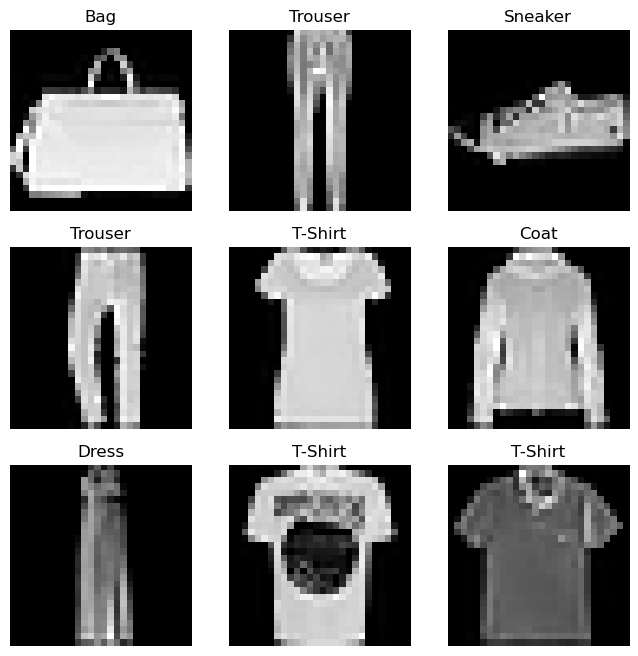

In [3]:
# 데이터셋을 순회하고 시각화하기
# Dataset 에 리스트(list)처럼 직접 접근(index)할 수 있습니다: 
# training_data[index]. matplotlib 을 사용하여 
# 학습 데이터의 일부를 시각화해보겠습니다.
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

 

# figure() 은 Figure 인스턴스를 생성하는데 이미지 전체의 영역 확보
figure = plt.figure(figsize=(8, 8)) # 8,8 인치의영역 확보 
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # item 함수는 tensor 변수에서 값만을가져온다 단, 갯수는 한개여야만한다. 
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    
    # img dtype-> tensor 
    # label dtype -> int
    img, label = training_data[sample_idx]
    
    # plt.figure() 로 그래프 그리기 위해서는 subplot 을 추가할 필요가 있다.
    # subplot 의 추가는 add_subplot 메소드를 사용한다. 
    figure.add_subplot(rows, cols, i)
    # rows 와 cols 는 고정값 i 는 변동값
    # rows 행 cols 열 i 번쨰의미다. 
    
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") # cmap 옵션으로 흑백으로바꿈 
plt.show()

In [4]:
# 파일에서 사용자 정의 데이터셋 만들기
# 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 합니다: 
# __init__, __len__, and __getitem__. 
# 아래 구현을 살펴보면 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 
# 정답은 annotations_file csv 파일에 별도로 저장됩니다.

# 다음 장에서 각 함수들에서 일어나는 일들을 자세히 살펴보겠습니다.


import os
import pandas as pd
from torchvision.io import read_image # 이미지 텐서로 변환

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


#  __init__
#  __init__ 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행됩니다. 
# 여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 (다음 장에서 자세히 살펴볼) 
# 두가지 변형(transform)을 초기화합니다.

# labels.csv 파일은 다음과 같습니다:

# tshirt1.jpg, 0
# tshirt2.jpg, 0
# ......
# ankleboot999.jpg, 9



# __len__
# __len__ 함수는 데이터셋의 샘플 개수를 반환합니다.


# __getitem__
# __getitem__ 함수는 주어진 인덱스 idx 에 해당하는 샘플을 
# 데이터셋에서 불러오고 반환합니다. 

# 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, 
# read_image 를 사용하여 이미지를 텐서로 변환하고,
# self.img_labels 의 csv 데이터로부터 해당하는 정답(label)을 가져오고, 
# (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, 
# 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환합니다.



In [5]:
# DataLoader로 학습용 데이터 준비하기
# Dataset 은 데이터셋의 특징(feature)을 가져오고 
# 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 합니다. 
# 모델을 학습할 때, 일반적으로 샘플들을 《미니배치(minibatch)》로 전달하고,
# 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, 
# Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이려고 합니다.


# DataLoader 는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 
# 가능한 객체(iterable)입니다.


from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
tensor([1, 6, 1, 7, 9, 3, 4, 1, 6, 8, 4, 1, 8, 7, 2, 0, 4, 1, 6, 1, 2, 5, 1, 7,
        0, 5, 7, 8, 1, 5, 7, 4, 6, 8, 2, 8, 5, 7, 7, 2, 2, 1, 1, 2, 4, 8, 6, 7,
        5, 3, 0, 7, 4, 0, 3, 5, 1, 9, 5, 0, 5, 4, 0, 5])


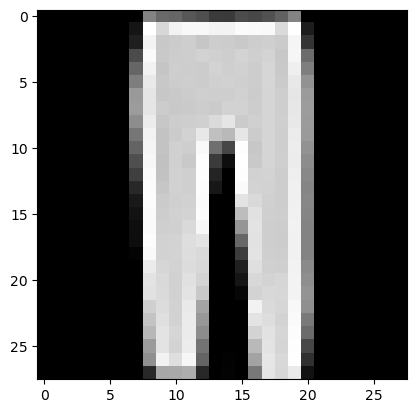

Label: 1


In [9]:
# DataLoader를 통해 순회하기(iterate)


# DataLoader 에 데이터셋을 불러온 뒤에는 
# 필요에 따라 데이터셋을 순회(iterate)할 수 있습니다. 


# 아래의 각 순회(iteration)는 
# (각각 batch_size=64 의 특징(feature)과 정답(label)을 포함하는) 
# train_features 와 train_labels 의 묶음(batch)을 반환합니다. 
# shuffle=True 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다. 
# (데이터 불러오기 순서를 보다 세밀하게(finer-grained) 제어하려면 Samplers 를 살펴보세요.)


# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
